# Прогнозирование кол-во заказов такси

## Задача

На основе исторических данных таксомоторной фирмы, необходимо построить модель для прогнозирования кол-во заказов такси на следующий час

## Критерии

- Значение метрики RMSE на тестовой выборке не должно быть больше 48
- Тестовая выборка должна быть 10% от исходных данных

# Шаг 1. Загрузка и анализ данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
from math import sqrt
 
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler

from statsmodels.tsa.seasonal import seasonal_decompose

from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

from catboost import CatBoostRegressor
from xgboost.sklearn import XGBRegressor

In [2]:
try:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except FileNotFoundError:
    data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


В признаке num_orders содежится кол-во заказов такси, что соответствует описанию и проверим порядок индексов на всякий случай

In [3]:
data.sort_index(inplace=True)
data.index.is_monotonic

True

In [4]:
print(f'Дата начала наблюдений: {data.index.min()}')
print(f'Дата окончания наблюдений: {data.index.max()}')
print(f'Временной отрезок: {data.index.max() - data.index.min()}')

Дата начала наблюдений: 2018-03-01 00:00:00
Дата окончания наблюдений: 2018-08-31 23:50:00
Временной отрезок: 183 days 23:50:00


<b>Вывод:</b>
- данные загружены
- описание соответствует содержанию
- данные представлены во временном интервале с 01.03.2018 по 31.08.2018

# Шаг 2. Анализ данных

Сначала проведем ресемплирование, затем построим графики трендов, сезонности

In [5]:
data_hour = data.resample('1H').sum()
data_month = data.resample('1M').sum()

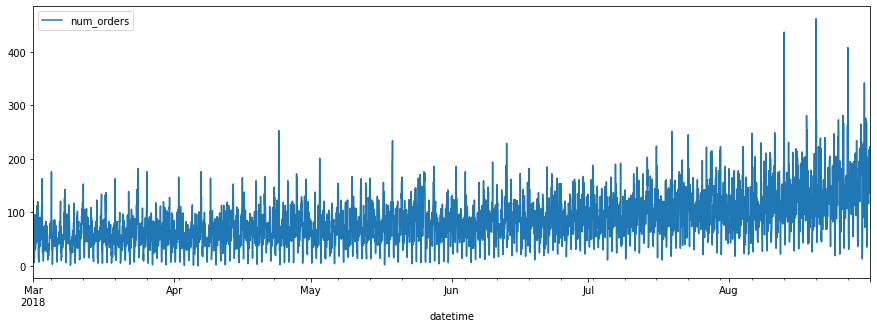

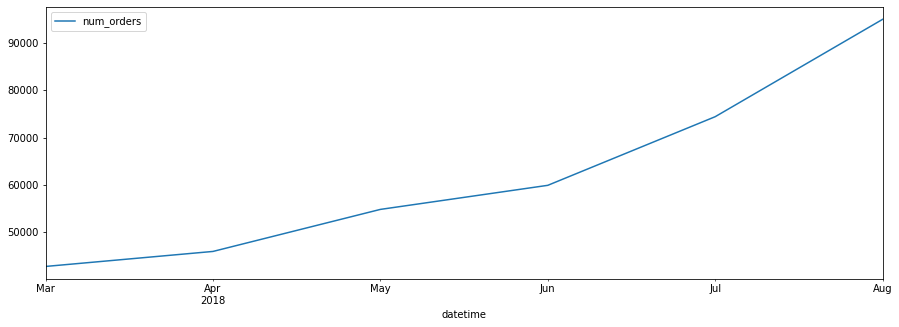

In [6]:
data_hour.plot(figsize=(15, 5))
data_month.plot(figsize=(15, 5));

Оценим сезонную декомпозицию

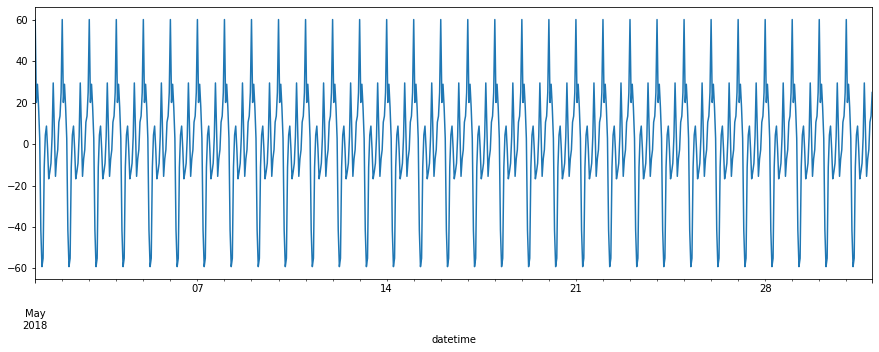

In [7]:
seasonal_decompose(data_hour).seasonal['2018-05':'2018-05'].plot(figsize=(15, 5));

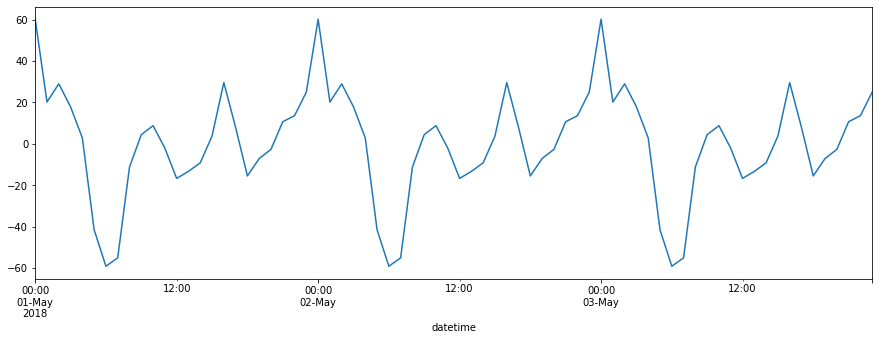

In [8]:
seasonal_decompose(data_hour).seasonal['2018-05-01':'2018-05-03'].plot(figsize=(15, 5));

<b>Предвательный вывод:</b>
- в данных присуствует устойчивый тренд на увеличение заказов по всей выборке
- график сезонности для одного месяца выглядит вполне стационарным
- на графиках отчетливо видно увеличение загрузки вечером с пиком в полночь и резким падением к 6 утра. Также наблюдаются постоянные локальные максимумы примерно в 10.00 и 15.00
- из графиков видно, что нам необходимо будет добавить такие признаки как месяц, день, день недели, час. Также считаю необходимым добавить признак выходного дня, чтобы выделить нагрузку в выходные дни.

# Шаг 3. Обучение модели с разными гиперпараметрами

Для начала напишем ф-цию добавления признаков. Исходя из выводов выше добавляем - месяц, число, день, час, также лаги и скользящее среднее.

In [9]:
def make_data(raw_data, max_lag, rolling_mean_size):
    
    def is_dayoff(row):
        return 1 if row['day_of_week'] > 5 else 0
    
    data = raw_data.copy()
#     data['month'] = data.index.month
#     data['day'] = data.index.day
    data['day_of_week'] = data.index.dayofweek
    data['hour'] = data.index.hour
    data['day_off'] = data.apply(is_dayoff, axis=1)    
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    for lag in range(1, max_lag + 1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)
        
    train, test = train_test_split(data, shuffle=False, test_size=.1)
    train.dropna(inplace=True)

    X_train = train.drop('num_orders', axis=1)
    y_train = train['num_orders']
    X_test = test.drop('num_orders', axis=1)
    y_test = test['num_orders']
    
    return X_train, y_train, X_test, y_test

Приступим к обучению.
1. Создадим общий список для всех результатов экспериментов
2. Заведем словари со списком алгоритмов и перебираемых гиперпараметров к ним
3. Обучим модели
4. Получим общий список с результатами всех экспериметов

In [10]:
# model, best_test_rmse, train_rmse, work_time, best_lag, best_rolling
results = []

In [11]:
dict_regressors = {
#     'Linear Regression': LinearRegression(),
#     'Lasso': Lasso(),
#     'Ridge': Ridge(),
#     'LightGBM Regressor': LGBMRegressor(),
#     'CatBoost Regressor': CatBoostRegressor(verbose=False),
    'XGB Regressor': XGBRegressor()
}

In [12]:
params = {
    'Linear Regression': {},
    'Lasso': {'alpha': [0, .1, .01]},
    'Ridge': {'alpha': [0, .1, .01]},
    'LightGBM Regressor': {
        'max_depth': [10, 15, 20, 25],
        'n_estimators': [400, 700, 1000],
        'learning_rate': [0.1, 0.3, 0.5, 0.7]},
    'CatBoost Regressor': {
        'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'iterations': [30, 50, 100], 
        'verbose': [False]},
    'XGB Regressor': {
        'learning_rate': [.03, 0.05, .07],
        'max_depth': [5, 6, 7],
        'n_estimators': [400, 700, 1000]}
}

In [13]:
%%time

# for lag in range(21, 35, 5):
for lag in [31]:
#     for rolling in range(1, 15, 5):
    for rolling in [6]:
        X_train, y_train, X_test, y_test = make_data(data_hour, max_lag=lag, rolling_mean_size=rolling)
        tscv = TimeSeriesSplit(n_splits=4)
        for classifier_name in dict_regressors.keys() & params:
            start = time.time()
#             print(f'training: {classifier_name}')
            model = dict_regressors[classifier_name]
            gs = GridSearchCV(
                estimator=model, 
                param_grid=params[classifier_name], 
                cv=tscv, 
                scoring='neg_mean_squared_error',
                n_jobs=-1
            ).fit(X_train, y_train)
            rmse_valid = round(sqrt(-gs.best_score_), 4)
            prediction = gs.best_estimator_.predict(X_test)
            rmse_test = round(sqrt(mean_squared_error(y_test, prediction)), 4)
            work_time = time.time() - start
            results.append([classifier_name, rmse_test, rmse_valid, work_time, lag, rolling, gs.best_estimator_])

CPU times: total: 23.6 s
Wall time: 42.3 s


In [14]:
results = pd.DataFrame(results, columns=['model_name', 'best_test_rmse', 'train_rmse', 'work_time', 'best_lag', 'best_rolling', 'model'])
results

,model_name,best_test_rmse,train_rmse,work_time,best_lag,best_rolling,model
0,XGB Regressor,39.8993,25.7644,42.294095,31,6,"XGBRegressor(base_score=0.5, booster='gbtree',..."


# Шаг 4. Анализ полученных результатов

1. Проанализируем список в целом
2. Получим параметры лучшей модели
3. Повторно ее обучим и визуализируем результат

In [15]:
results.sort_values(by='best_test_rmse')

,model_name,best_test_rmse,train_rmse,work_time,best_lag,best_rolling,model
0,XGB Regressor,39.8993,25.7644,42.294095,31,6,"XGBRegressor(base_score=0.5, booster='gbtree',..."


Линейные алгоритмы показывают в целом результаты хуже. Но стоит отметить, что при небольшом проигрыше в обобщающей способности, они имеют солидный задел в быстродействии. Также стоит отметить, что при более широком моделировании похожие результаты достигались при небольшом кол-ве лагов и окне скользящего среднего > 50. Я считаю, что подобные не совсем корректными и окно в 6 записей пожалуй самый оптимальный результат.

In [16]:
best_result = results.sort_values(by='best_test_rmse').reset_index(drop=True)[:1]
best_result

,model_name,best_test_rmse,train_rmse,work_time,best_lag,best_rolling,model
0,XGB Regressor,39.8993,25.7644,42.294095,31,6,"XGBRegressor(base_score=0.5, booster='gbtree',..."


In [17]:
new_data = pd.DataFrame({'num_orders': [0, 0]}, index=pd.DatetimeIndex(['2018-09-01 00:00:00', '2018-09-01 01:00:00']))
new_data_hour = data_hour.append(new_data)
display(new_data_hour)

,num_orders
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 21:00:00,159
2018-08-31 22:00:00,223
2018-08-31 23:00:00,205
2018-09-01 00:00:00,0


In [18]:
X_train, y_train, X_test, y_test = make_data(
    new_data_hour, 
    max_lag=best_result.loc[0]['best_lag'], 
    rolling_mean_size=best_result.loc[0]['best_rolling']
)

In [19]:
X_pred = X_test['2018-09-01']
y_pred = y_test['2018-09-01']
X_test = X_test[:'2018-09-01']
y_test = y_test[:'2018-09-01']

In [20]:
model = best_result.loc[0]['model'].fit(X_train, y_train)
prediction_train = pd.Series(model.predict(X_train), index=y_train.index, name='prediction_train')
prediction_test = pd.Series(model.predict(X_test), index=y_test.index, name='prediction_test')
prediction = pd.Series(model.predict(X_pred), index=y_pred.index, name='prediction')
data_compare = pd.concat([prediction_train, prediction_test, prediction], axis=1)
data_compare.head()

,prediction_train,prediction_test,prediction
2018-03-02 07:00:00,11.655689,NaN,NaN
2018-03-02 08:00:00,44.676186,NaN,NaN
2018-03-02 09:00:00,55.548851,NaN,NaN
2018-03-02 10:00:00,58.618267,NaN,NaN
2018-03-02 11:00:00,78.186211,NaN,NaN


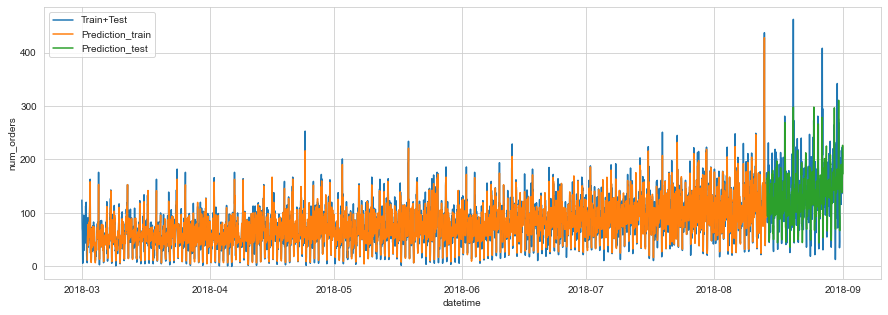

In [21]:
plt.figure(figsize=(15, 5))
sns.set_style('whitegrid')
sns.lineplot(x=data_hour.index, y=data_hour['num_orders'], label='Train+Test')
sns.lineplot(x=data_compare.index, y=data_compare['prediction_train'], label='Prediction_train')
sns.lineplot(x=data_compare.index, y=data_compare['prediction_test'], label='Prediction_test');

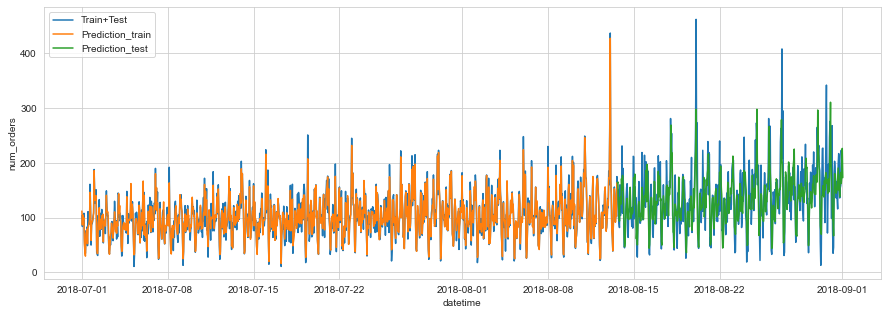

In [22]:
plt.figure(figsize=(15, 5))
sns.set_style('whitegrid')
data = data_compare['2018-07':]
sns.lineplot(x=data_hour['2018-07':].index, y=data_hour['2018-07':]['num_orders'], label='Train+Test')
sns.lineplot(x=data.index, y=data['prediction_train'], label='Prediction_train')
sns.lineplot(x=data.index, y=data['prediction_test'], label='Prediction_test');

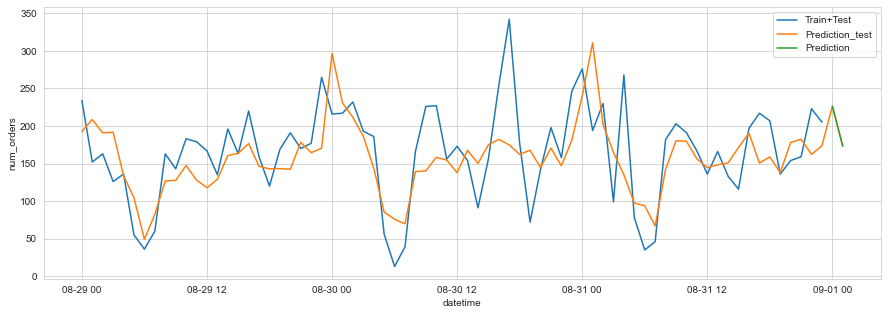

In [23]:
plt.figure(figsize=(15, 5))
sns.set_style('whitegrid')
data = data_compare['2018-08-29':]
sns.lineplot(x=data_hour['2018-08-29':].index, y=data_hour['2018-08-29':]['num_orders'], label='Train+Test')
sns.lineplot(x=data.index, y=data['prediction_test'], label='Prediction_test');
sns.lineplot(x=data.index, y=data['prediction'], label='Prediction');

In [24]:
data['prediction']['2018-09-01']

2018-09-01 00:00:00    226.489700
2018-09-01 01:00:00    173.081528
Freq: H, Name: prediction, dtype: float32

На сравнительном графике тестовых результатов и предсказаний лучшей модели отчетливо видно тенденцию в обобщающей способности. Большинство пиков и спадов моделью предсказано правильно. Заметны промахи при малых локальных изменениях. В целом модель получилась неплоха для качественной оценки. В случае если будет требоваться более детальный прогноз, то потребуются уточнения.

# Вывод

1. данные во временном интервале с 01.03.2018 по 31.08.2018 загружены и соответствуют описанию.
2. при анализе данных обнаружен общий устойчивый тренд на увеличение заказов по всей выборке. График сезонности для одного месяца выглядит вполне стационарным. Отчетливо видно увеличение загрузки вечером с пиком в полночь и резким падением к 6 утра. Также наблюдаются постоянные локальные максимумы примерно в 10.00 и 15.00. Как результат для дальнейшего моделирования необходимо добавить признаки содержащие месяц, день, день недели, час, выходной/рабочий день.
3. Было проведено моделирование со следующими алгоритмами:
- Linear Regression
- Lasso
- Ridge
- LightGBM Regressor
- CatBoost Regressor
- XGB Regressor
4. Анализ результатов моделирования показал, что линейные алгоритмы немного проигрывают в точности предсказания, но при этом имеют солидное преймущество по времени обучения. При анализе лучшей из полученых моделей видно, что она в целом неплохо предсказывает общее поведение графика, но при этом допускает ошибки с небольшими локальными изменениями.
5. Лучшее значение RMSE получилось для модели XGBRegressor - 39.8. Исходя из предсказаний данной модели, в 00:00 и 01:00 потребуется 226 и 173 такси соответственно.